# Computation of the Probability of Profit With the Lognormal Distribution
In this notebook, you will learn how to compute the probability of profit with the lognormal distribution. It is one of the most commonly used in the financial industry among practitioners. That is why it is important to learn this. We will use the code provided in the lognormal distribution notebook to compute the necessary inputs, and then calculate the probability of profit accordingly. 

✅ 1. Lognormal Approximation (Analytic)
	•	Assumes asset price S_T \sim \text{LogNormal}(\mu, \sigma^2 T)
	•	Use CDF \Phi(\cdot) to compute probability of landing in a profit region
	•	Fast and elegant, but:
	•	Assumes continuous distribution
	•	No skew, kurtosis, or jump modeling
	•	No accounting for early exercise (OK for European-style options)

✅ Use when:
	•	Trade is defined-risk (e.g., condors, butterflies)
	•	You just want quick ballpark estimate

--- 

🔁 2. Monte Carlo Simulation
•	Simulate many paths for the underlying using geometric Brownian motion:
$S_T = S_0 \cdot e^{\left(\mu - \frac{1}{2} \sigma^2\right)T + \sigma \sqrt{T} Z}$
•	For each path, compute final strategy payoff
•	POP = fraction of simulations with payoff ≥ 0

✅ Use when:
•	Strategy is complex (e.g., calendars, diagonals)
•	You want to model volatility skew, fat tails, or custom drift
•	You’re working in a backtesting framework

⚠️ Requires more compute time but much more flexible.

✅ Step 1: What Makes a Model “Better”?

A model is “better” if it:
	•	Accurately reflects the real-world behavior of the underlying
	•	Captures features relevant to your strategy (e.g., volatility skew, jumps)
	•	Is tractable enough to simulate or estimate outcomes
	•	Improves decision-making (better POP, EV, hedging)

You should match the model’s complexity to the structure and sensitivity of your trade.

🔁 Step 4: Test & Compare — Empirically

To know which model is better in practice, do comparative simulations:

Example Procedure:
	1.	Fix a trade (e.g., iron condor on SPX, 30 DTE)
	2.	Simulate N paths under:
	•	GBM (lognormal)
	•	Skewed normal
	•	Student-t
	•	Jump-diffusion
	3.	Compute for each:
	•	POP
	•	Expected P&L
	•	Tail risk (95th percentile loss)
	4.	Compare → Which aligns best with backtested outcomes?

You can also:
	•	Backtest vs historical paths (e.g., rolling SPY trades over 10 years)
	•	Check which model produces similar option price surfaces to market IVs

The notebook is structured as follows:
1. [Import the Data](#import)
2. [Set the Analysis Date](#date)
3. [Compute the Expected Volatility Until Expiry](#expected_volatility)
4. [Plot the Lognormal Distribution](#lognormal)
5. [Compute the Long Butterfly Strategy Payoff](#long_payoff)
6. [Plot the Lognormal Distribution and Profit Zones](#profit_zones)
7. [Compute the Probability of Profit](#pop)
8. [Define the Summary Functions](#functions)
8. [Compute the Short Butterfly Strategy Probability of Profit](#short_pop)

## Import Libraries
We import the libraries necessary for our analysis.

In [2]:
# For data manipulation
import pandas as pd
import numpy as np
from datetime import timedelta

# For data visualisation
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-v0_8-darkgrid')

# Ignore warnings
import warnings 
warnings.filterwarnings('ignore')

# For lognormal distribution
from scipy.stats import lognorm

# For option's payoff computations
import sys
sys.path.append('..')
from data_modules.options_util_quantra import setup_butterfly, get_payoff

<a id='import'></a>
## Import the Data
We import the futures and options data of the NIFTY index to compute the probability of profit.

In [3]:
# Read the options data
options_data = pd.read_pickle('../data_modules/nifty_options_data_2019_2022.bz2')

# Read the futures data
futures_spot_data = pd.read_pickle('../data_modules/nifty_data_2019_2022.bz2')

# Print the first 5 rows of the futures data
futures_spot_data.head()

,spot_open,spot_high,spot_low,spot_close,Expiry,futures_close
Date,,,,,,
2019-01-01,10881.70,10923.60,10807.10,10910.10,2019-01-31,10960.55
2019-01-02,10868.85,10895.35,10735.05,10792.50,2019-01-31,10830.85
2019-01-03,10796.80,10814.05,10661.25,10672.25,2019-01-31,10718.50
2019-01-04,10699.70,10741.05,10628.65,10727.35,2019-01-31,10777.60
2019-01-07,10804.85,10835.95,10750.15,10771.80,2019-01-31,10803.45


<a id='date'></a>
## Set the Analysis Date
In order to create the butterfly strategy, we choose a date to make the analysis and select the data based on it.

In [4]:
# Set the analysis date
analysis_date = "2021-01-01"

# Fetch the futures close price that corresponds to the above date
futures_price = futures_spot_data.loc[analysis_date, 'futures_close']

# Fetch the options chain data that belongs to the above date
options_chain = options_data.loc[analysis_date]

# Compute start date
start_date = pd.to_datetime(analysis_date) - timedelta(days=90)

# Select the 90-day historical data from the futures prices
futures_spot_data = futures_spot_data.loc[start_date:analysis_date]

# Compute start date
f"The futures price on {analysis_date} is {futures_price}"

'The futures price on 2021-01-01 is 14053.85'

<a id='expected_volatility'></a>
## Compute the Expected Volatility Until Expiry
In order to create the lognormal-distributed random prices, we need to calculate the expected volatility until expiry, named as `vol_normalised`.

In [5]:
# Compute the daily spot log returns
daily_returns = np.log(futures_spot_data.spot_close /
                       futures_spot_data.spot_close.shift(1))

# Compute the historical volatility
daily_historical_volatility = daily_returns.std()

# Compute the days to expiry
days_to_expiry = (
    futures_spot_data.Expiry[-1] - futures_spot_data.index[-1]).days

# Compute the trading days to expiry
trading_days_to_expiry = round(days_to_expiry * (5/7))

# Compute the normalised volatility
vol_normalised = daily_historical_volatility * np.sqrt(trading_days_to_expiry)

# Print the normalised volatility
f'The expected volatility for {days_to_expiry} days is {round(vol_normalised*100,2)}%'

'The expected volatility for 27 days is 3.93%'

<a id='lognormal'></a>
## Plot the Lognormal Distribution
Before we plot the histogram and the lognormal distribution, we transform the mean and standard deviation to their lognormal distribution values.

In [6]:
# Last traded price
mean = futures_price

# Deviation in price
stdev = vol_normalised * mean

# Computation of phi to transform the mean and standard deviation to lognormal values
phi = (stdev ** 2 + mean ** 2) ** 0.5

# Computation of the lognormal mean
mu = np.log(mean ** 2 / phi)

# Computation of the lognormal standard deviation
sigma = (np.log(phi ** 2 / mean ** 2)) ** 0.5

# Print the 3 values
f"Phi: {round(phi,2)}, mu: {round(mu,2)}, sigma: {round(sigma,2)}"

'Phi: 14064.69, mu: 9.55, sigma: 0.04'

Here we plot the histogram of the lognormally-distributed generated prices together with the lognormal probability density function values represented with a black line.

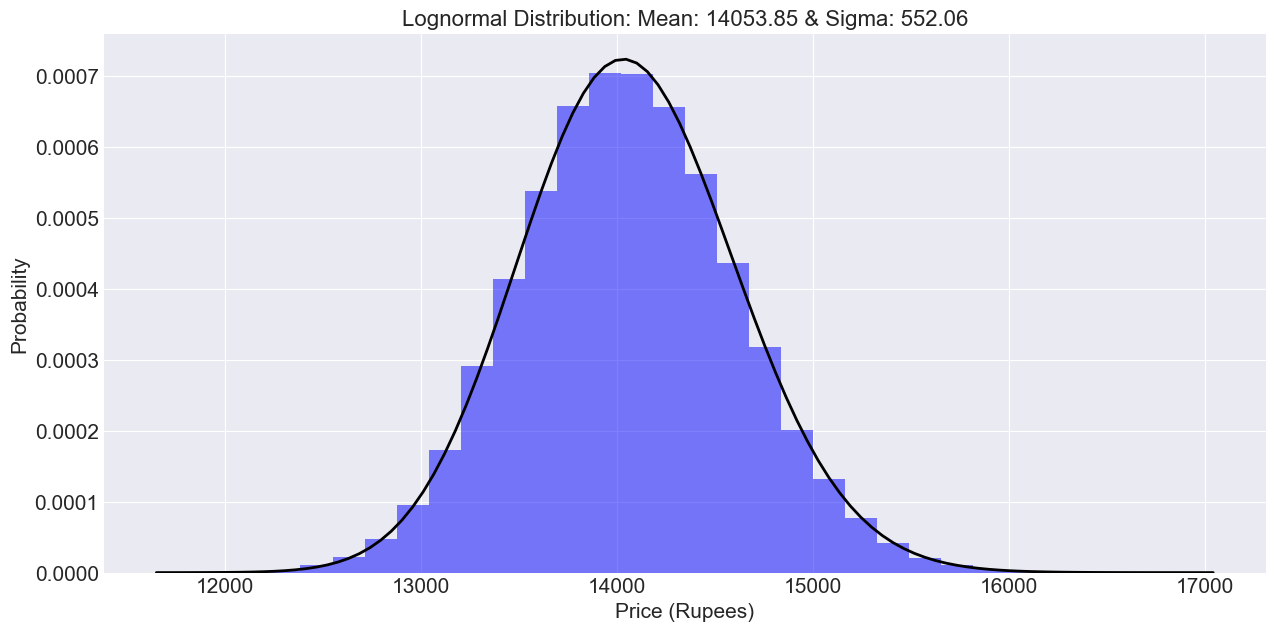

In [7]:
# Generate 50000 lognormally-distributed prices
prices = np.random.lognormal(mu, sigma, 50000)

# Set figure size
plt.figure(figsize=(15, 7))

# Set the histogram parameters
plt.hist(prices, bins=30, density=True, alpha=0.5, color='b')

# Set the horizontal axis limits
xmin, xmax = plt.xlim()

# Set the price frequency for the graph
x = np.linspace(xmin, xmax, 100)

# Compute the probability values from the lognormal distribution
p = lognorm.pdf(x=x, scale=mean, s=sigma)

# Plot the histogram
plt.plot(x, p, 'k', linewidth=2)

# Set the title and labels and their sizes
title = "Lognormal Distribution: Mean: {:.2f} & Sigma: {:.2f}".format(
    mean, stdev)
plt.title(title, fontsize=16)
plt.xlabel('Price (Rupees)', fontsize=15)
plt.ylabel('Probability', fontsize=15)
plt.tick_params(axis='both', labelsize=15)

# Show the graph
plt.show()

<a id='long_payoff'></a>
## Compute the Long Butterfly Strategy Payoff
Next, we compute the long butterfly strategy payoff. We use the code done previously in the 'Payoff Diagram' and the 'Setup Butterfly Strategy' notebooks.

In [8]:
# Setup the butterfly strategy
butterfly = setup_butterfly(futures_price, options_chain, "long")

# Compute the net premium
net_premium = (butterfly.position * butterfly.premium).sum()*-1

# Print the net premium
print(f"Net Premium is {net_premium}")

# Create the payoff dataframe
payoff = pd.DataFrame()

# Compute the price range
payoff['price_range'] = list(options_chain['Strike Price'].unique())

# Compute the payoff diagram values
payoff['pnl'] = payoff.apply(
    lambda r: get_payoff(r.price_range, butterfly), axis=1)

# Set price_range as index
payoff.set_index('price_range', inplace=True)

butterfly

Net Premium is 387.5


,Option Type,Strike Price,position,premium,payoff
0,CE,14050,-1,280.75,-1169.25
1,PE,14050,-1,279.00,279.00
2,CE,14600,1,69.25,830.75
3,PE,13500,1,103.00,-103.00


Let's plot the payoff diagram now.

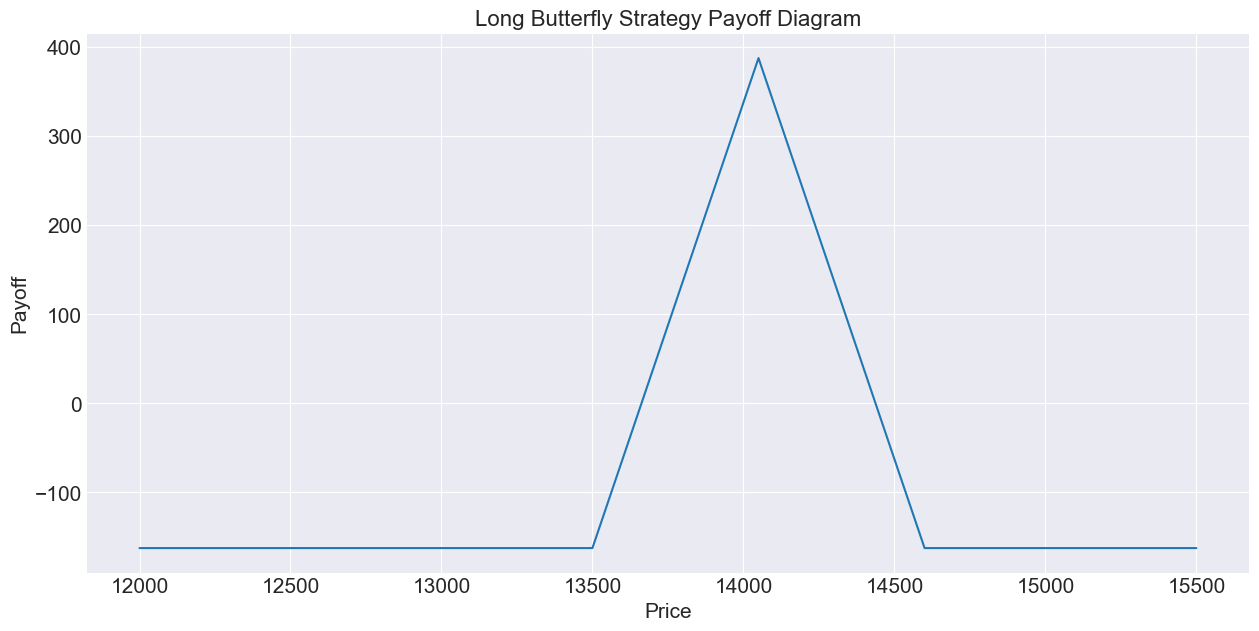

In [9]:
# Set figure size
plt.figure(figsize=(15, 7))

# Plot the payoff data
plt.plot(payoff)

# Set the title and labels and their sizes
plt.title('Long Butterfly Strategy Payoff Diagram', fontsize=16)
plt.xlabel('Price', fontsize=15)
plt.ylabel('Payoff', fontsize=15)
plt.tick_params(axis='both', labelsize=15)

# Show the graph
plt.show()

<a id='profit_zones'></a>
## Plot the Lognormal Distribution and Profit Zones
Next, we compute the lognormal distribution values as per the `price_range` together with the butterfly strategy payoff values. This graph has already been provided in the 'Lognormal Distribution' notebook. Here we add something interesting: Let's divide the payoff diagram into positive and negative zones. The graph will be filled in three parts.

1. Green colour: The green-coloured zone will represent the prices for which the payoff is positive. It goes from the lowest to the highest prices that correspond to the `price_range` and to the positive payoff values. This colour will fill the middle part.
2. Red colour: The red-coloured zone will represent the prices for which the payoff is negative. It consists of 2 parts: 
    - First part: It goes from the lowest price value in the `price_range`, up to the lowest price that corresponds to the positive payoff values. The left coloured zone represents this first part.
    - Second part: It goes from the highest price that corresponds to the positive payoff values, up to the highest price in the `price_range`. The right coloured zone represents this second part.

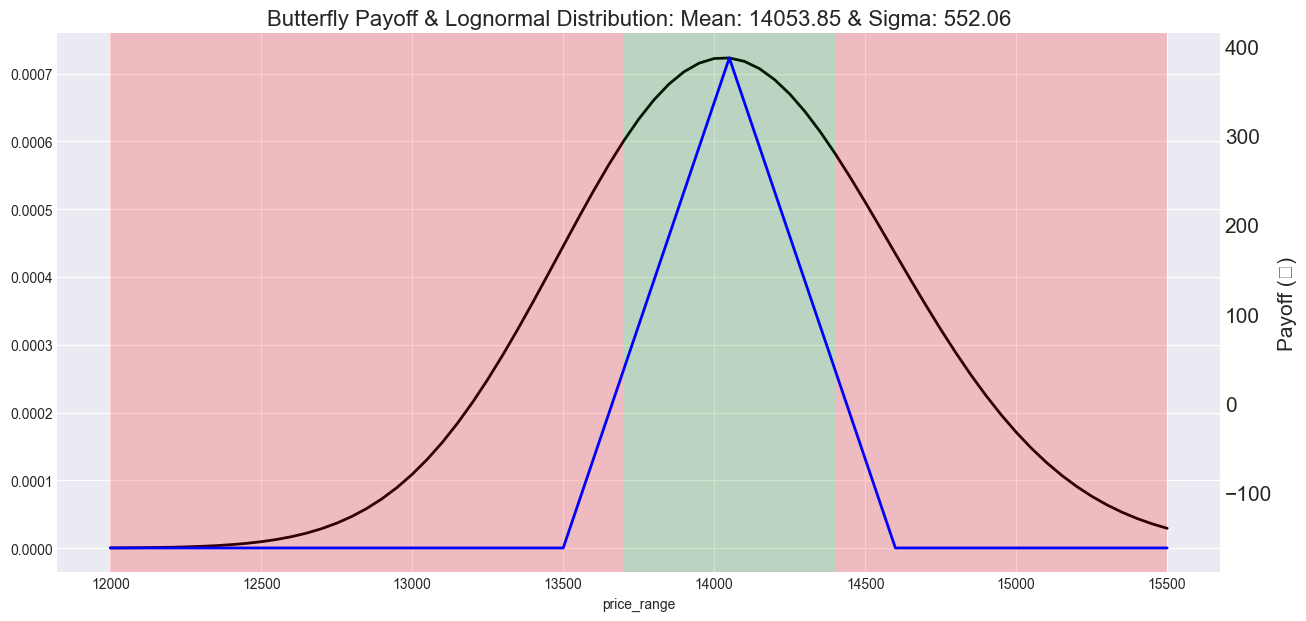

In [10]:
# Compute the lognormal-distributed probability values for the payoff price range
p = lognorm.pdf(x=payoff.index, scale=mean, s=sigma)

# Set figure size
ax = plt.figure(figsize=(15, 7))

# Plot Gold futures price and position
ax = plt.plot(payoff.index, p, 'k', linewidth=2)

# Plot the payoff values as a secondary axis
ax2 = payoff.pnl.plot(secondary_y=True, color='blue', linewidth=2)

# Fill the graph with a red colour from the lowest price up to the minimum positive-payoff price
plt.axvspan(payoff.index.min(),
            payoff[payoff.pnl > 0].index.min(), facecolor='r', alpha=0.2)

# Fill the graph with a red colour from the maximum positive-payoff price up to the highest price
plt.axvspan(payoff[payoff.pnl > 0].index.max(),
            payoff.index.max(), facecolor='r', alpha=0.2)

# Fill the graph with a green colour between the minimum and maximum positive-payoff price
plt.axvspan(payoff[payoff.pnl > 0].index.min(),
            payoff[payoff.pnl > 0].index.max(), facecolor='g', alpha=0.2)

# Set the title and labels and their sizes
title = "Butterfly Payoff & Lognormal Distribution: Mean: {:.2f} & Sigma: {:.2f}".format(
    mean, stdev)
plt.title(title, fontsize=16)
plt.xlabel('Price (₹)', fontsize=15)
plt.ylabel('Probability', fontsize=15)
ax2.set_ylabel('Payoff (₹)', fontsize=15)
plt.tick_params(axis='both', labelsize=15)
ax2.tick_params(axis='both', labelsize=15)

# Show the graph
plt.show()

<a id='pop'></a>
## Compute the Probability of Profit
Before we do this important computation, let's write the following code lines. First, we are going to compute the cumulative density function values that we actually did in the previous notebook:

In [11]:
# Compute the probability of each price in the price_range
payoff['cdf_lognormal'] = lognorm.cdf(x=payoff.index, scale=mean, s=sigma)

As the name says, these probability values will increase from 0 to 1 as you go from the first to the last price in the `price_range`. You don't want a cumulative probability, you actually want a probability that is concerned only with the specific price you have in each row. 

In order to obtain these values, you have to compute the difference in probability between a price and its corresponding previous price, such that you get the probability specific to that price.

In [12]:
# Compute lognormal-distributed probability for each price with respect to its previous value
payoff['lognormal_probability'] = payoff['cdf_lognormal'].diff()

Now, we want the probability of profit. The profit is represented by the green-coloured zone shown in the previous graph, which is nothing but the zone where the strategy makes money. 

We already have the probability for each price value in the `price_range`. So, what about making a sum of all the probabilities that correspond to the only-positive-payoff prices? Easy to interpret, right? Let's code:

In [13]:
# Compute the probability of profit for the butterfly strategy
pop_lognormal = payoff[payoff.pnl > 0].lognormal_probability.sum()

# Print the probability of profit
f'The probability of profit is {round(pop_lognormal*100,2)}%'

'The probability of profit is 50.34%'

<a id='functions'></a>
## Create the Summary Functions
In the previous notebook, we created functions to have all the code encapsulated in functions. Let's do something similar here. These functions are going to be useful when you're going to backtest your strategy in the upcoming units.

The first function will compute the lognormal probability for a butterfly strategy. The only 2 inputs you need are the futures and spot data and also the price range which you will use to compute the payoff values of the strategy.

In [14]:
def get_lognormal_probability(futures_spot_data, price_range):

    # ---------------------- Compute Volatility ---------------------
    # Compute the daily spot log returns
    daily_returns = np.log(futures_spot_data.spot_close /
                           futures_spot_data.spot_close.shift(1))

    # Compute the historical volatility
    daily_historical_volatility = daily_returns.std()

    # Compute the days to expiry
    days_to_expiry = (
        futures_spot_data.Expiry[-1] - futures_spot_data.index[-1]).days

    # Compute the normalised volatility
    vol_normalised = daily_historical_volatility * np.sqrt(days_to_expiry)

    # ---------------------- Lognormal parameters ---------------------
    # Last traded price
    mean = futures_spot_data['futures_close'][-1]

    # Deviation in price
    stdev = vol_normalised * mean

    phi = (stdev ** 2 + mean ** 2) ** 0.5
    mu = np.log(mean ** 2 / phi)
    sigma = (np.log(phi ** 2 / mean ** 2)) ** 0.5
    f"Phi: {round(phi,2)}, mu: {round(mu,2)}, sigma: {round(sigma,2)}"

    # Create a dataframe setting the price_range as its index
    prob = pd.DataFrame(index=price_range)

    # Compute the cumulative density function values based on the price range
    prob['cdf_lognormal'] = lognorm.cdf(x=prob.index, scale=mean, s=sigma)

    # Compute the lognormal probability for each price
    prob['lognormal_probability'] = prob['cdf_lognormal'].diff()

    # Return the lognormal probability values
    return prob['lognormal_probability']

The second function presented below will use the above function to get the probability of profit for you. It will use 3 inputs: 
1. `futures_spot_data`: The futures and spot data,
2. `price_range`: The range of price values which we will be used to create the payoff for the butterfly strategy, 
3. `options_strategy`: The options_strategy dataframe

In [18]:
def get_pop_lognormal(futures_spot_data, price_range, options_strategy):

    # Create the payoff dataframe
    payoff = pd.DataFrame()

    # Compute the price range
    payoff['price_range'] = price_range

    # Compute the payoff diagram values
    payoff['pnl'] = payoff.apply(lambda r: get_payoff(
        r.price_range, options_strategy), axis=1)

    # Set price_range as index
    payoff.set_index('price_range', inplace=True)

    # Compute the lognormal probability for each price
    payoff['lognormal_probability'] = get_lognormal_probability(
        futures_spot_data, price_range)

    # Compute the probability of profit for the strategy
    pop_lognormal = payoff[payoff.pnl > 0].lognormal_probability.sum()

    # Return the rounded probability of profit in percentage terms
    return round(pop_lognormal*100, 2)

<a id='short_pop'></a>
## Compute the Short Butterfly Strategy Probability of Profit
Let's compute the short butterfly strategy in this case. We will use the summary functions defined above.

First, we generate the short butterfly strategy dataframe:

In [19]:
# Get the short butterfly strategy dataframe
short_butterfly = setup_butterfly(futures_price, options_chain, 'short')

# Print the short butterfly dataframe
short_butterfly

,Option Type,Strike Price,position,premium
0,CE,14050,1,280.75
1,PE,14050,1,279.00
2,CE,14600,-1,69.25
3,PE,13500,-1,103.00


Let's compute the probability of profit for the short butterfly strategy. We are going to use the summary functions to get the desired output faster.

In [20]:
# Define the price range to create the payoff values
price_range = options_chain['Strike Price'].unique()

# Compute the probability of profit
pop_lognormal = get_pop_lognormal(
    futures_spot_data, price_range, short_butterfly)

# Print the probability of profit
f'The probability of profit is {pop_lognormal}%'

'The probability of profit is 54.97%'

## Conclusion
Using some of the functions and code from the previous notebooks, we computed the lognormal-distributed probability of profit in this notebook. We also wrote two functions that you can use later for backtesting. In the upcoming unit, you will learn how to compute the probability of profit with an empirical distribution.<br><br>